# HealthCare Risk Score
## Group Memebers
* Priya Bhardwaj
* Reza Ghaemi
* Umang Mittal

### About this project:


##### In this project we are calculating the HealthCare Risk Score which is a Medicare prospective payment methodology utilizing the patients conditions to adjust  payment to health plans based on several attributes that assess Providers member population based on health conditions and other demographic factors. 

##### Our goal here is s a health insurer, we need a better understanding of how chronic conditions affect the HCC Risk Score since that is the driving source of revenue for the Medicare population

##### We also want to be able to predict current years batch of providers Avg. Risk Score using their member data. This Will help identify high revenue opportunity provider and low revenue opportunity providers which can help for contracting. With our predictions, we will have a good understanding of what we can expect CMS to pay us. Eventually we can build an application to use live claims data to adjust the providers HCC Risk Score to give us real time analytics 

#### Source and lineage of Data :

##### This is real public healthcare data provided by CMS. Since Medicare is a govenrment based program, at the provider level is public as long as there is no PHI involved. This data does no include any member details.

##### We were able to access the data through Kaggle. https://www.kaggle.com/cms/medicare-physician-other-supplier-npi-aggregates#medicare-physician-and-other-supplier-national-provider-identifier-npi-aggregate-report-calendar-year-2014.csv
** This dataset has been kept on google drive since download link for kaggle changes with every login and hence cannot be made static.

###### Shell Script to checks if tensorflow is installed or not(Considering we are using python2).
###### If tensorflow is not installed it installs it else nothing.

In [4]:
%sh

tensorflow=$(python -c 'import tensorflow as tf;print(tf.__version__)')

if [ -z "$tensorflow" ]
then
  pip install tensorflow
fi

###### Restarting python since Tensorflow cannot be imported without it.

In [6]:
dbutils.library.restartPython()

In [7]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import datetime 

In [8]:
%sh
wget https://raw.githubusercontent.com/circulosmeos/gdown.pl/master/gdown.pl
chmod +x gdown.pl

--2019-05-04 17:34:42-- https://raw.githubusercontent.com/circulosmeos/gdown.pl/master/gdown.pl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2072 (2.0K) [text/plain]
Saving to: ‘gdown.pl.1’

 0K .. 100% 32.6M=0s

2019-05-04 17:34:42 (32.6 MB/s) - ‘gdown.pl.1’ saved [2072/2072]

In [9]:
%sh
./gdown.pl https://drive.google.com/open?id=1Hx_tjJULQXkLFsDvLbEIRwbq-0gRk0ls healthCare.csv

Cannot open cookies file ‘gdown.cookie.temp’: No such file or directory
--2019-05-04 17:34:42-- https://docs.google.com/uc?id=1Hx_tjJULQXkLFsDvLbEIRwbq-0gRk0ls&export=download
Resolving docs.google.com (docs.google.com)... 216.58.193.78, 2607:f8b0:400a:809::200e
Connecting to docs.google.com (docs.google.com)|216.58.193.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘healthCare.csv’

 0K 11.7M=0s

2019-05-04 17:34:42 (11.7 MB/s) - ‘healthCare.csv’ saved [3346]

--2019-05-04 17:34:42-- https://docs.google.com/uc?export=download&confirm=Bi-c&id=1Hx_tjJULQXkLFsDvLbEIRwbq-0gRk0ls
Resolving docs.google.com (docs.google.com)... 216.58.193.78, 2607:f8b0:400a:809::200e
Connecting to docs.google.com (docs.google.com)|216.58.193.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3tnbff9v130to51ubhlvtfvh2kpgvhr2/1556985600000/13349984215183314838/*/1Hx_tjJULQXkLFsDvLbEIRwbq-0gRk0ls?e=download [following]
Warning: wildcards not supported in HTTP.
--2019-05-04 17:34:43-- https://doc-0s-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3tnbff9v130to51ubhlvtfvh2kpgvhr2/1556985600000/13349984215183314838/*/1Hx_tjJULQXkLFsDvLbEIRwbq-0gRk0ls?e=download
Resolving doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-docs.googleusercontent.com)... 172.217.164.97, 2607:f8b0:400a:803::2001
Connecting to doc-0s-6c-docs.googleusercontent.com (doc-0s-6c-docs.googleusercontent.com)|172.217.164.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘healthCare.csv’

 0K ........ ........ ........ ........ 63.3M
 32768K ........ ........ ........ ........ 116M
 65536K ........ ........ ........ ........ 106M
 98304K ........ ........ ........ ........ 108M
131072K ........ ........ ........ ........ 109M
163840K ........ ........ ........ ........ 111M
196608K ........ ........ ........ ........ 80.1M
229376K ........ ........ ........ ........ 71.0M
262144K ........ ........ ........ ........ 86.5M
294912K ........ ........ ........ 92.1M=3.4s

2019-05-04 17:34:46 (90.7 MB/s) - ‘healthCare.csv’ saved [327526352]

In [10]:
# Reading the file to pyspark dataframe such that first row is header and the scehma is decided by pyspark

frame=spark.read.csv('file:///databricks/driver/healthCare.csv',header='true', inferSchema ='true')

### Explanation of origninal set of attributes:

##### This dataset has 68 attributes. The data is at the individual provider level. Meaning we have the providers name and Identifier (NPI) and other demographics such as location. As well as the providers demographics data, we also have some common stats in terms of claim submissions from the provider and how many claims were submitted. We also have the distribution in percentage of the members demographics the provider has seen in the past year. There is also the provider populations member distribution of chronic illnesses (HCC's). We know that HCC or Hierarchical condition category coding is a risk-adjustment model originally designed to estimate future health care costs for patients and is the driving factor when it comes to perdicting the HCC Risk Score.

In [12]:
frame.printSchema()

root
-- National Provider Identifier: integer (nullable = true)
-- Last Name/Organization Name of the Provider: string (nullable = true)
-- First Name of the Provider: string (nullable = true)
-- Middle Initial of the Provider: string (nullable = true)
-- Credentials of the Provider: string (nullable = true)
-- Gender of the Provider: string (nullable = true)
-- Entity Type of the Provider: string (nullable = true)
-- Street Address 1 of the Provider: string (nullable = true)
-- Street Address 2 of the Provider: string (nullable = true)
-- City of the Provider: string (nullable = true)
-- Zip Code of the Provider: string (nullable = true)
-- State Code of the Provider: string (nullable = true)
-- Country Code of the Provider: string (nullable = true)
-- Provider Type of the Provider: string (nullable = true)
-- Medicare Participation Indicator: string (nullable = true)
-- Number of HCPCS: integer (nullable = true)
-- Number of Services: double (nullable = true)
-- Number of Medicare Beneficiaries: integer (nullable = true)
-- Total Submitted Charge Amount: double (nullable = true)
-- Total Medicare Allowed Amount: double (nullable = true)
-- Total Medicare Payment Amount: double (nullable = true)
-- Total Medicare Standardized Payment Amount: double (nullable = true)
-- Drug Suppress Indicator: string (nullable = true)
-- Number of HCPCS Associated With Drug Services: integer (nullable = true)
-- Number of Drug Services: double (nullable = true)
-- Number of Medicare Beneficiaries With Drug Services: integer (nullable = true)
-- Total Drug Submitted Charge Amount: double (nullable = true)
-- Total Drug Medicare Allowed Amount: double (nullable = true)
-- Total Drug Medicare Payment Amount: double (nullable = true)
-- Total Drug Medicare Standardized Payment Amount: double (nullable = true)
-- Medical Suppress Indicator: string (nullable = true)
-- Number of HCPCS Associated With Medical Services: integer (nullable = true)
-- Number of Medical Services: double (nullable = true)
-- Number of Medicare Beneficiaries With Medical Services: integer (nullable = true)
-- Total Medical Submitted Charge Amount: double (nullable = true)
-- Total Medical Medicare Allowed Amount: double (nullable = true)
-- Total Medical Medicare Payment Amount: double (nullable = true)
-- Total Medical Medicare Standardized Payment Amount: double (nullable = true)
-- Average Age of Beneficiaries: integer (nullable = true)
-- Number of Beneficiaries Age Less 65: integer (nullable = true)
-- Number of Beneficiaries Age 65 to 74: integer (nullable = true)
-- Number of Beneficiaries Age 75 to 84: integer (nullable = true)
-- Number of Beneficiaries Age Greater 84: integer (nullable = true)
-- Number of Female Beneficiaries: integer (nullable = true)
-- Number of Male Beneficiaries	: integer (nullable = true)
-- Number of Non-Hispanic White Beneficiaries	: integer (nullable = true)
-- Number of Black or African American Beneficiaries: integer (nullable = true)
-- Number of Asian Pacific Islander Beneficiaries: integer (nullable = true)
-- Number of Hispanic Beneficiaries: integer (nullable = true)
-- Number of American Indian/Alaska Native Beneficiaries: integer (nullable = true)
-- Number of Beneficiaries With Race Not Elsewhere Classified: integer (nullable = true)
-- Number of Beneficiaries With Medicare Only Entitlement: integer (nullable = true)
-- Number of Beneficiaries With Medicare & Medicaid Entitlement: integer (nullable = true)
-- Percent (%) of Beneficiaries Identified With Atrial Fibrillation: integer (nullable = true)
-- Percent (%) of Beneficiaries Identified With Alzheimer’s Disease or Dementia: integer (nullable = true)
-- Percent (%) of Beneficiaries Identified With Asthma: integer (nullable = true)
-- Percent (%) of Beneficiaries Identified With Cancer: integer (nullable = true)
-- Percent (%) of Beneficiaries Identified With Heart Failure: integer (nullable = true)
-- Percent (%) of Beneficiaries Identified With Chronic Kidney Disease: int

#### Renaming Columns for easier data Frame handling

In [14]:
frame = frame.withColumnRenamed("National Provider Identifier","NPI")
frame = frame.withColumnRenamed("Last Name/Organization Name of the Provider", "lName")
frame = frame.withColumnRenamed("First Name of the Provider", "fName")
frame = frame.withColumnRenamed("Middle Initial of the Provider", "mInitial")
frame = frame.withColumnRenamed("Credentials of the Provider", "Credentials")
frame = frame.withColumnRenamed("Gender of the Provider", "Gender")
frame = frame.withColumnRenamed("Entity Type of the Provider", "Entity")
frame = frame.withColumnRenamed("Street Address 1 of the Provider", "StreetAddress1")
frame = frame.withColumnRenamed("Street Address 2 of the Provider", "StreetAddress2")
frame = frame.withColumnRenamed("Zip Code of the Provider", "ZipCode")
frame = frame.withColumnRenamed("Country Code of the Provider", "CountryCode")
frame = frame.withColumnRenamed("Provider Type of the Provider", "Type")
frame = frame.withColumnRenamed("Medicare Participation Indicator", "Indicator")
frame = frame.withColumnRenamed("Number of HCPCS", "HCPCS")
frame = frame.withColumnRenamed("Number of Medicare Beneficiaries", "Beneficiaries")
frame = frame.withColumnRenamed("Total Submitted Charge Amount", "TotalChargeAmt")
frame = frame.withColumnRenamed("Total Medicare Allowed Amount", "TotalAllowedAmt")
frame = frame.withColumnRenamed("Total Medicare Standardized Payment Amount", "TotalPaymentAmt")
frame = frame.withColumnRenamed("Drug Suppress Indicator", "DrugIndicator")
frame = frame.withColumnRenamed("Number of HCPCS Associated With Drug Services", "HCPCSDrugServices")
frame = frame.withColumnRenamed("Number of Drug Services", "DrugServices")
frame = frame.withColumnRenamed("Number of Medicare Beneficiaries With Drug Services", "BeneficiariesWDrugServices")
frame = frame.withColumnRenamed("Total Drug Submitted Charge Amount", "TotalDrugChargeAmt")
frame = frame.withColumnRenamed("Total Drug Medicare Allowed Amount", "TotalDrugAllowedAmt")
frame = frame.withColumnRenamed("Total Drug Medicare Payment Amount", "TotalDrugPaymentAmt")
frame = frame.withColumnRenamed("Total Drug Medicare Standardized Payment Amount", "TotalDrugStdPaymentAmt")

In [15]:
frame = frame.withColumnRenamed("City of the Provider", "City")
frame = frame.withColumnRenamed("State Code of the Provider", "State")
frame = frame.withColumnRenamed("Number of Services", "Services")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Atrial Fibrillation", "Percent_AtrialFibrillation")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Alzheimer’s Disease or Dementia", "Percent_Alzheimers_Dementia")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Asthma", "Percent_Asthma")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Cancer", "Percent_Cancer")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Heart Failure", "Percent_HeartFailure")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Chronic Kidney Disease", "Percent_ChronicKidneyDisease")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Chronic Obstructive Pulmonary Disease", "Percent_ChronicObstructivePulmonaryDisease")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Depression", "Percent_Depression")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Diabetes", "Percent_Diabetes")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Hyperlipidemia", "Percent_Hyperlipidemia")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Hypertension", "Percent_Hypertension")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Ischemic Heart Disease", "Percent_IschemicHeartDisease")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Osteoporosis", "Percent_Osteoporosis")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Rheumatoid Arthritis / Osteoarthritis", "Percent_RheumatoidArthritis_Osteoarthritis")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Schizophrenia / Other Psychotic Disorders", "Percent_Schizophrenia_OtherPsychoticDisorders")
frame = frame.withColumnRenamed("Percent (%) of Beneficiaries Identified With Stroke", "Percent_Stroke")
frame = frame.withColumnRenamed("Average HCC Risk Score of Beneficiaries", "Avg_HCC_Risk_Score")

In [16]:
frame.printSchema()

root
-- NPI: integer (nullable = true)
-- lName: string (nullable = true)
-- fName: string (nullable = true)
-- mInitial: string (nullable = true)
-- Credentials: string (nullable = true)
-- Gender: string (nullable = true)
-- Entity: string (nullable = true)
-- StreetAddress1: string (nullable = true)
-- StreetAddress2: string (nullable = true)
-- City: string (nullable = true)
-- ZipCode: string (nullable = true)
-- State: string (nullable = true)
-- CountryCode: string (nullable = true)
-- Type: string (nullable = true)
-- Indicator: string (nullable = true)
-- HCPCS: integer (nullable = true)
-- Services: double (nullable = true)
-- Beneficiaries: integer (nullable = true)
-- TotalChargeAmt: double (nullable = true)
-- TotalAllowedAmt: double (nullable = true)
-- Total Medicare Payment Amount: double (nullable = true)
-- TotalPaymentAmt: double (nullable = true)
-- DrugIndicator: string (nullable = true)
-- HCPCSDrugServices: integer (nullable = true)
-- DrugServices: double (nullable = true)
-- BeneficiariesWDrugServices: integer (nullable = true)
-- TotalDrugChargeAmt: double (nullable = true)
-- TotalDrugAllowedAmt: double (nullable = true)
-- TotalDrugPaymentAmt: double (nullable = true)
-- TotalDrugStdPaymentAmt: double (nullable = true)
-- Medical Suppress Indicator: string (nullable = true)
-- Number of HCPCS Associated With Medical Services: integer (nullable = true)
-- Number of Medical Services: double (nullable = true)
-- Number of Medicare Beneficiaries With Medical Services: integer (nullable = true)
-- Total Medical Submitted Charge Amount: double (nullable = true)
-- Total Medical Medicare Allowed Amount: double (nullable = true)
-- Total Medical Medicare Payment Amount: double (nullable = true)
-- Total Medical Medicare Standardized Payment Amount: double (nullable = true)
-- Average Age of Beneficiaries: integer (nullable = true)
-- Number of Beneficiaries Age Less 65: integer (nullable = true)
-- Number of Beneficiaries Age 65 to 74: integer (nullable = true)
-- Number of Beneficiaries Age 75 to 84: integer (nullable = true)
-- Number of Beneficiaries Age Greater 84: integer (nullable = true)
-- Number of Female Beneficiaries: integer (nullable = true)
-- Number of Male Beneficiaries	: integer (nullable = true)
-- Number of Non-Hispanic White Beneficiaries	: integer (nullable = true)
-- Number of Black or African American Beneficiaries: integer (nullable = true)
-- Number of Asian Pacific Islander Beneficiaries: integer (nullable = true)
-- Number of Hispanic Beneficiaries: integer (nullable = true)
-- Number of American Indian/Alaska Native Beneficiaries: integer (nullable = true)
-- Number of Beneficiaries With Race Not Elsewhere Classified: integer (nullable = true)
-- Number of Beneficiaries With Medicare Only Entitlement: integer (nullable = true)
-- Number of Beneficiaries With Medicare & Medicaid Entitlement: integer (nullable = true)
-- Percent_AtrialFibrillation: integer (nullable = true)
-- Percent_Alzheimers_Dementia: integer (nullable = true)
-- Percent_Asthma: integer (nullable = true)
-- Percent_Cancer: integer (nullable = true)
-- Percent_HeartFailure: integer (nullable = true)
-- Percent_ChronicKidneyDisease: integer (nullable = true)
-- Percent_ChronicObstructivePulmonaryDisease: integer (nullable = true)
-- Percent_Depression: integer (nullable = true)
-- Percent_Diabetes: integer (nullable = true)
-- Percent_Hyperlipidemia: integer (nullable = true)
-- Percent_Hypertension: integer (nullable = true)
-- Percent_IschemicHeartDisease: integer (nullable = true)
-- Percent_Osteoporosis: integer (nullable = true)
-- Percent_RheumatoidArthritis_Osteoarthritis: integer (nullable = true)
-- Percent_Schizophrenia_OtherPsychoticDisorders: integer (nullable = true)
-- Percent_Stroke: integer (nullable = true)
-- Avg_HCC_Risk_Score: double (nullable = true)

##### Limiting the dataset to US only and then droping the column
##### Removing String Columns except for State and City since they cannot be used in numerical analysis.

In [18]:
frame = frame.where("CountryCode='US'")
frame=frame.drop('NPI','lName','fName','Credentials','Gender','Entity','StreetAddress1','StreetAddress2','CountryCode','Type','Indicator','DrugIndicator','Medical Suppress Indicator')

#### Calculating correlation of all integer valued columns

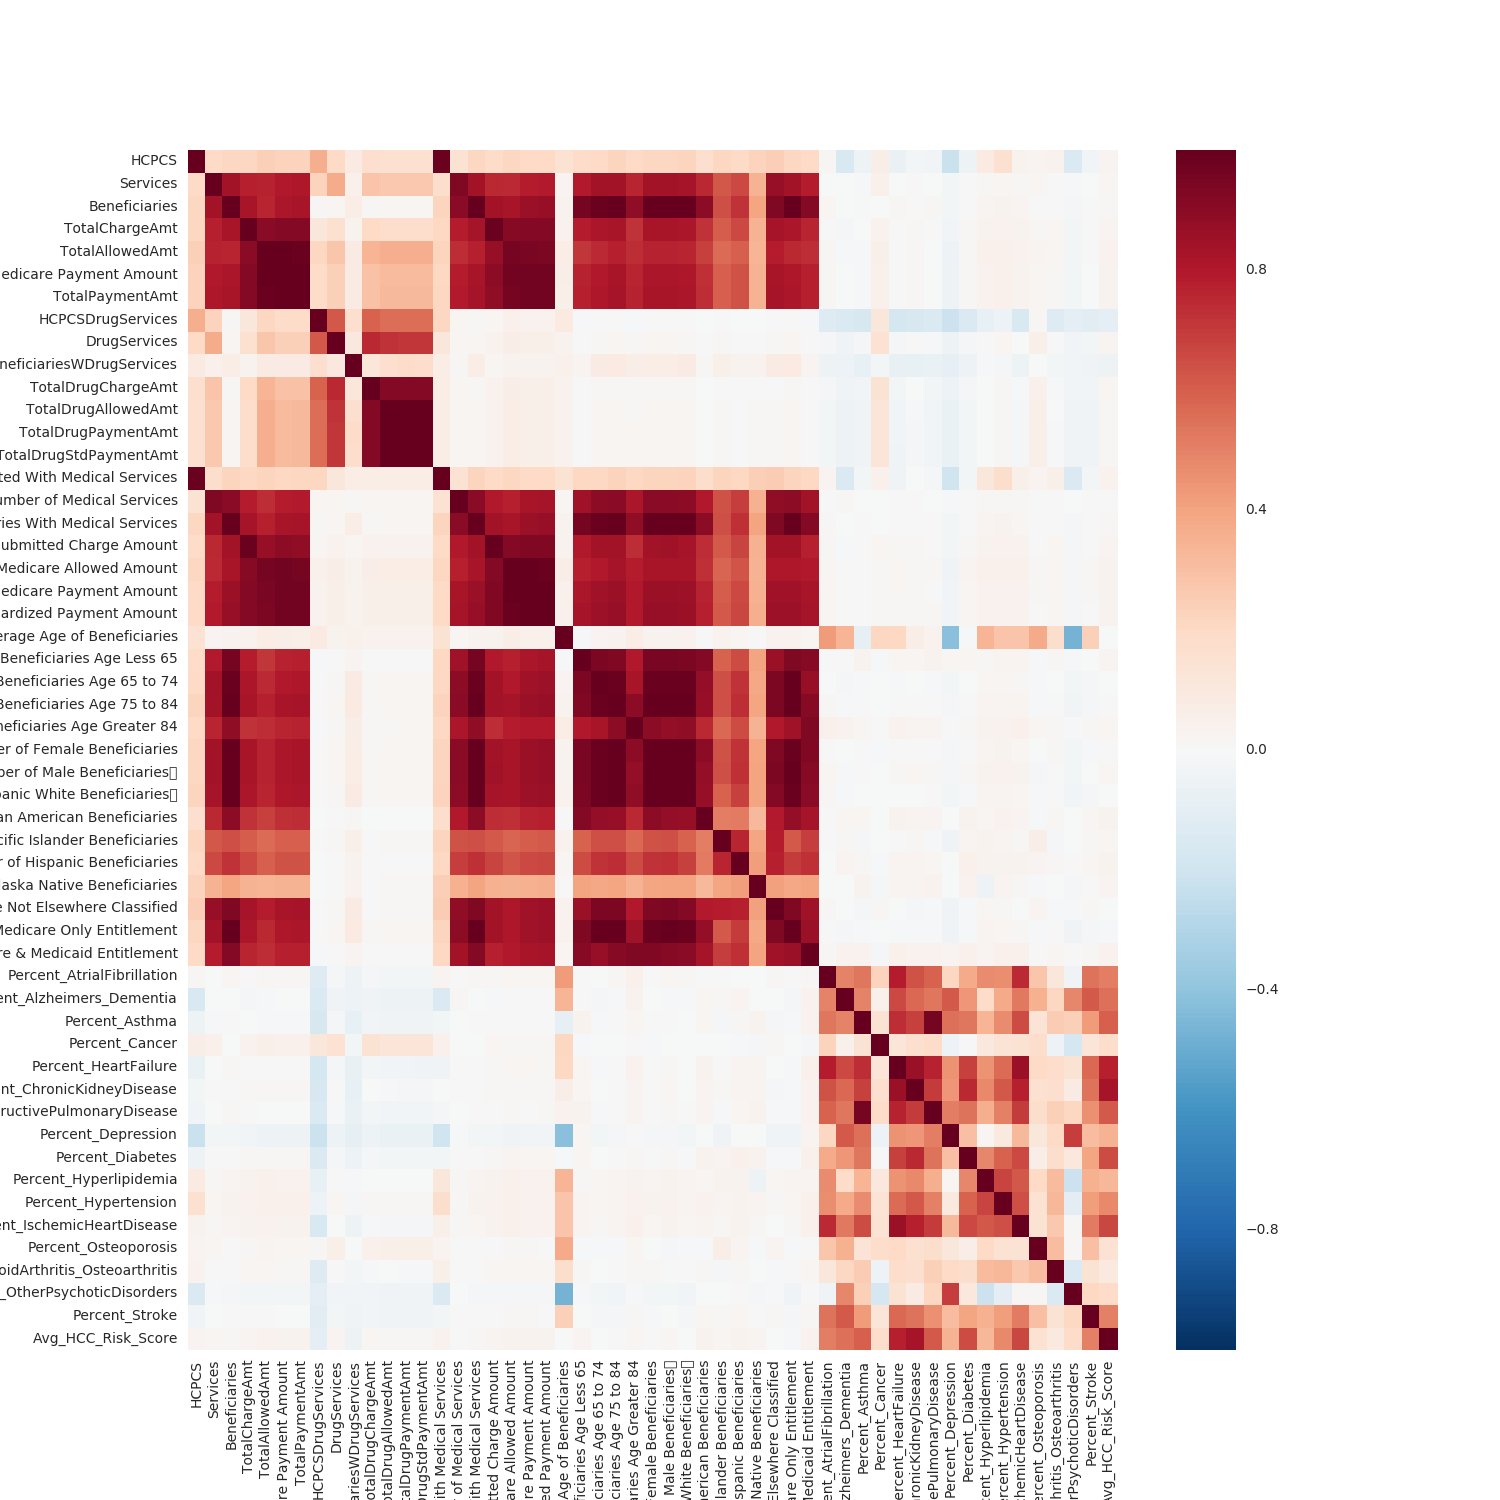

In [20]:
# Making a new pandas dataframe using the original spark dataframe to run correlation of all columns with all other columns.
# droping string value columns from correlation calculations

framePd=frame.toPandas()

import matplotlib.pyplot as plt 
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
corr=framePd.corr()
sns.heatmap(corr)
display(fig)

#### Choosing columns which are not strongly correlated to HCC Risk Score.

In [22]:
frame=frame.select('City','State','Percent_AtrialFibrillation','Percent_Asthma','Percent_Cancer','Percent_ChronicKidneyDisease','Percent_HeartFailure','Percent_ChronicObstructivePulmonaryDisease','Percent_Depression','Percent_Diabetes','Percent_Hyperlipidemia','Percent_IschemicHeartDisease','Percent_Osteoporosis','Percent_RheumatoidArthritis_Osteoarthritis','Percent_Schizophrenia_OtherPsychoticDisorders','Percent_Stroke','Avg_HCC_Risk_Score','Percent_Alzheimers_Dementia')

### Key Attributes Explained:

#### Predictors: 
##### We selected the 17 Hierarchical condition category (HCC) or chronic conditions that have a strong correlation to our target/label variable. These conditions are grouped at the population level and is explaining how many percent of the providers memeber population have these HCC condition groups.

#### Target / Label:
##### AVG_HCC_RISK_SCORE, this is nothing more than Risk Adjustment Factor (RAF) that determines payment to health plans based on the populations risk or chornic conditions (HCCs)

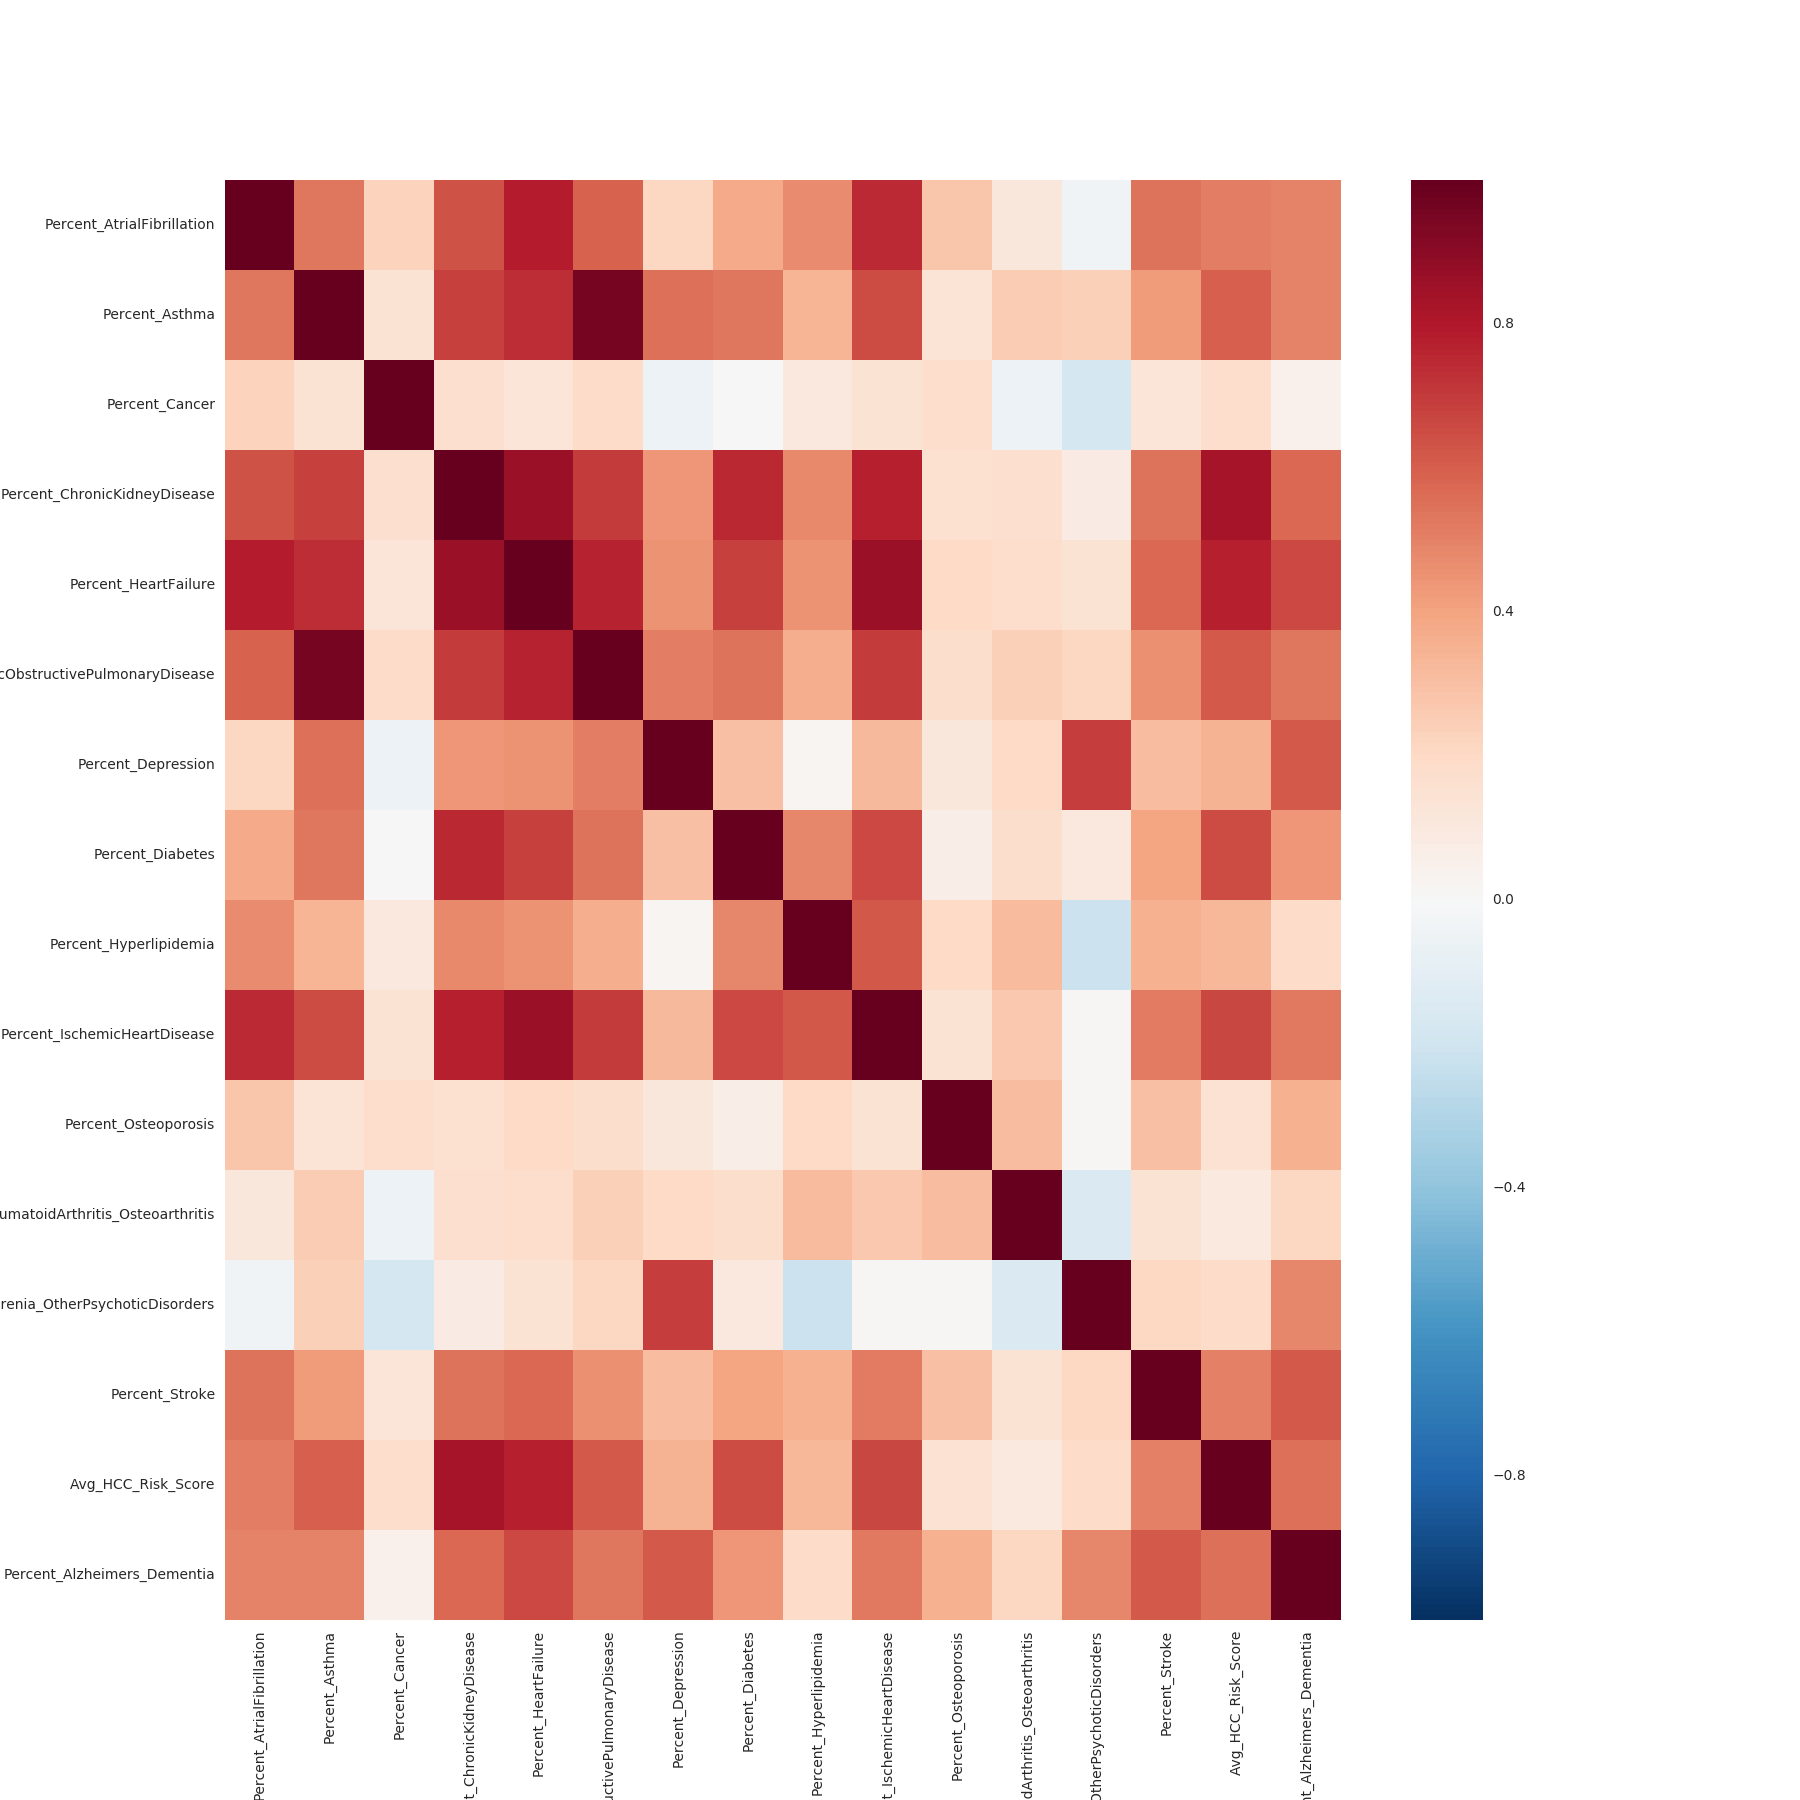

In [24]:
# Re-making the pandas dataframe using the original spark dataframe to run correlation of all columns with all other columns.
# droping string value columns from correlation calculations
framePd=frame.drop('State','City').toPandas()

fig, ax = plt.subplots()
fig.set_size_inches(18,18)
corr=framePd.corr()
sns.heatmap(corr)
display(fig)

#### Checking count of null values in dataset

In [26]:
framePd.isnull().sum()

Out[ 13 ]: 
Percent_AtrialFibrillation 340406
Percent_Asthma 238937
Percent_Cancer 347003
Percent_ChronicKidneyDisease 174264
Percent_HeartFailure 264894
Percent_ChronicObstructivePulmonaryDisease 281675
Percent_Depression 166574
Percent_Diabetes 149135
Percent_Hyperlipidemia 81746
Percent_IschemicHeartDisease 158069
Percent_Osteoporosis 397690
Percent_RheumatoidArthritis_Osteoarthritis 101243
Percent_Schizophrenia_OtherPsychoticDisorders 546995
Percent_Stroke 476836
Avg_HCC_Risk_Score 0
Percent_Alzheimers_Dementia 346348
dtype: int64

#### Getting statistics of data set

In [28]:
display(frame.summary())

summary,City,State,Percent_AtrialFibrillation,Percent_Asthma,Percent_Cancer,Percent_ChronicKidneyDisease,Percent_HeartFailure,Percent_ChronicObstructivePulmonaryDisease,Percent_Depression,Percent_Diabetes,Percent_Hyperlipidemia,Percent_IschemicHeartDisease,Percent_Osteoporosis,Percent_RheumatoidArthritis_Osteoarthritis,Percent_Schizophrenia_OtherPsychoticDisorders,Percent_Stroke,Avg_HCC_Risk_Score,Percent_Alzheimers_Dementia
count,1053883,1053883,713477,814946,706880,879619,788989,772208,887309,904748,972137,895814,656193,952640,506888,577047,1053883,707535
mean,612.0,null,14.813965972273808,24.488283886294308,13.702334200995926,36.6781959007252,25.963288461562836,21.425240349750325,31.069646538015505,36.587082812009534,56.90412359574834,39.2755136668996,9.860470928522554,46.87381907121263,8.271580704218684,8.492498877907693,1.5995428758220802,17.992694354342895
stddev,NaN,null,8.98524182388672,11.362080890544224,9.937651783242778,16.378485918222747,15.692421163453263,11.67780218533228,15.120350021297687,12.48171257135203,12.172351041717281,15.077918346275796,5.366448903169821,12.761114730128739,12.922525704624915,7.992738106105567,0.7773629818439401,14.718622686278955
min,00612,AA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.3508,0
25%,612.0,null,9,16,9,24,14,13,20,28,49,28,7,38,0,4,1.0695,8
50%,612.0,null,13,23,12,34,22,19,28,35,58,37,9,45,5,7,1.3846,13
75%,612.0,null,19,31,16,48,36,28,38,44,66,49,12,54,9,12,1.9392,24
max,ZWOLLE,XX,75,75,75,75,75,75,75,75,75,75,75,75,75,75,11.955,75


### Transformation and Data cleaning:
##### We had lots of null values in our key predictor attributes. Rather than dorpping the null values and reduce the size of our dataset drastically. We decided to use a replace by co-locality methedology to replace the null values in all the above attributes with the city average for that attribute. This way we are considering only averages within the city rather than the whole dataset. 
##### Doing this transformation so the city by city average of each attrbute remains the same and we have enough data for training the model.

In [30]:
from pyspark.sql.functions import expr
frameAvg=frame.groupBy("City","State").agg( expr("avg(Percent_AtrialFibrillation) as avg_AtrialFibrillation"),expr("avg(Percent_Asthma) as avg_Asthma"),expr("avg(Percent_Cancer) as avg_Cancer"),expr("avg(Percent_ChronicKidneyDisease) as avg_ChronicKidneyDisease"),expr("avg(Percent_HeartFailure) as avg_HeartFailure"),expr("avg(Percent_ChronicObstructivePulmonaryDisease) as avg_ChronicObstructivePulmonaryDisease"),expr("avg(Percent_Depression) as avg_Depression"),expr("avg(Percent_Diabetes) as avg_Diabetes"),expr("avg(Percent_Hyperlipidemia) as avg_Hyperlipidemia"),expr("avg(Percent_IschemicHeartDisease) as avg_IschemicHeartDisease"),expr("avg(Percent_Osteoporosis) as avg_Osteoporosis"),expr("avg(Percent_RheumatoidArthritis_Osteoarthritis) as avg_RheumatoidArthritis_Osteoarthritis"),expr("avg(Percent_Schizophrenia_OtherPsychoticDisorders) as avg_Schizophrenia_OtherPsychoticDisorders"),expr("avg(Percent_Stroke) as avg_Stroke"),expr("avg(Avg_HCC_Risk_Score) as avg_Risk_Score"),expr("avg(Percent_Alzheimers_Dementia) as avg_Alzheimers_Dementia"))
display(frameAvg)

City,State,avg_AtrialFibrillation,avg_Asthma,avg_Cancer,avg_ChronicKidneyDisease,avg_HeartFailure,avg_ChronicObstructivePulmonaryDisease,avg_Depression,avg_Diabetes,avg_Hyperlipidemia,avg_IschemicHeartDisease,avg_Osteoporosis,avg_RheumatoidArthritis_Osteoarthritis,avg_Schizophrenia_OtherPsychoticDisorders,avg_Stroke,avg_Risk_Score,avg_Alzheimers_Dementia
STATEN ISLAND,NY,15.90625,24.313725490196077,13.80780209324453,38.6080971659919,31.034217279726263,21.701612903225808,30.140065146579804,50.68586387434555,65.21748554913295,48.450965250965254,8.753275109170305,48.873313343328334,10.424205378973106,9.485082872928176,1.8001440540540545,22.964814814814815
SARTELL,MN,12.633663366336634,18.128,10.89423076923077,30.53676470588235,18.50862068965517,14.294642857142858,31.90066225165563,27.043478260869566,42.4635761589404,26.94573643410853,8.663636363636364,49.42948717948718,5.078947368421052,5.680555555555555,1.293742441860465,10.384615384615385
BOWIE,MD,9.902912621359222,18.380165289256198,13.40566037735849,33.223021582733814,19.517241379310345,12.705357142857142,24.02238805970149,39.46,56.53125,31.569444444444443,7.021505376344086,48.63522012578616,8.222222222222221,7.851063829787234,1.3621698863636365,16.129310344827587
FORT SAM HOUSTON,TX,15.773584905660377,26.319444444444443,12.571428571428571,43.88157894736842,29.3943661971831,23.347826086956523,33.41095890410959,40.83116883116883,61.21176470588235,45.67088607594937,9.122448979591837,49.5609756097561,4.2105263157894735,10.291666666666666,1.8953031578947368,21.634920634920636
MARLBORO,NJ,17.233333333333334,20.513513513513512,14.516129032258064,33.65853658536585,30.34285714285714,19.75,28.47222222222222,44.116279069767444,67.5909090909091,46.5,9.32258064516129,53.906976744186046,6.7,11.130434782608695,1.5130574468085105,27.79310344827586
FRUITA,CO,8.5,17.515151515151516,7.916666666666667,22.0,12.607142857142858,13.962962962962964,26.44736842105263,26.314285714285713,30.916666666666668,20.833333333333332,10.869565217391305,41.61538461538461,7.0,4.8125,1.1424525,17.73076923076923
CHESTERFIELD,MO,16.639225181598064,21.102449888641427,14.995215311004785,32.231884057971016,25.112866817155755,18.149425287356323,29.799188640973632,30.062111801242235,59.696798493408664,38.65674603174603,11.103960396039604,53.260299625468164,4.7203065134099615,8.664688427299703,1.4360702127659575,16.84275184275184
FAIRFIELD,CA,12.834394904458598,23.55614973262032,12.091954022988507,40.131979695431475,24.730994152046783,18.89142857142857,27.253886010362695,38.41293532338308,54.516746411483254,35.69387755102041,9.265822784810126,42.85507246376812,6.871794871794871,9.316176470588236,1.602622844827586,15.528301886792454
COOKEVILLE,TN,15.761092150170649,31.477744807121663,11.761565836298933,35.882005899705014,30.996941896024463,29.878419452887538,34.3304347826087,37.30523255813954,57.42134831460674,42.65988372093023,9.11284046692607,51.37640449438202,7.904347826086957,9.16600790513834,1.5735658536585366,17.64505119453925
STATESBORO,GA,12.954954954954955,26.5546875,11.41747572815534,34.73913043478261,28.0,23.911290322580644,29.037037037037038,41.81428571428572,65.7687074829932,39.12230215827338,6.153846153846154,44.95804195804196,5.764044943820225,7.96875,1.5179013157894736,15.50909090909091


#### Replacing the above city average values using SQL's NVL function.
###### Droping the Temperory Views to keep the memory free.

In [32]:
frame.createOrReplaceTempView("frameView")
frameAvg.createOrReplaceTempView("avgView")

sqlQuery="select fv.City,fv.State,NVL(Percent_AtrialFibrillation,avg_AtrialFibrillation) AS Percent_AtrialFibrillation, NVL(Percent_Asthma,avg_Asthma) AS Percent_Asthma, NVL(Percent_Cancer,avg_Cancer) AS Percent_Cancer, NVL(Percent_ChronicKidneyDisease,avg_ChronicKidneyDisease) AS Percent_ChronicKidneyDisease, NVL(Percent_HeartFailure,avg_HeartFailure) AS Percent_HeartFailure, NVL(Percent_ChronicObstructivePulmonaryDisease,avg_ChronicObstructivePulmonaryDisease) AS Percent_ChronicObstructivePulmonaryDisease, NVL(Percent_Depression,avg_Depression) AS Percent_Depression, NVL(Percent_Diabetes,avg_Diabetes) AS Percent_Diabetes, NVL(Percent_Hyperlipidemia,avg_Hyperlipidemia) AS Percent_Hyperlipidemia, NVL(Percent_IschemicHeartDisease,avg_IschemicHeartDisease) AS Percent_IschemicHeartDisease, NVL(Percent_Osteoporosis,avg_Osteoporosis) AS Percent_Osteoporosis, NVL(Percent_RheumatoidArthritis_Osteoarthritis,avg_RheumatoidArthritis_Osteoarthritis) AS Percent_RheumatoidArthritis_Osteoarthritis, NVL(Percent_Schizophrenia_OtherPsychoticDisorders,avg_Schizophrenia_OtherPsychoticDisorders) AS Percent_Schizophrenia_OtherPsychoticDisorders, NVL(Percent_Stroke,avg_Stroke) AS Percent_Stroke, NVL(Avg_HCC_Risk_Score,avg_Risk_Score) AS Avg_HCC_Risk_Score, NVL(Percent_Alzheimers_Dementia,avg_Alzheimers_Dementia) AS Percent_Alzheimers_Dementia from frameView fv , avgView av where fv.City=av.City and fv.State=av.State"

frame = spark.sql(sqlQuery)
display(frame)
spark.catalog.dropTempView("frameView")
spark.catalog.dropTempView("avgView")

City,State,Percent_AtrialFibrillation,Percent_Asthma,Percent_Cancer,Percent_ChronicKidneyDisease,Percent_HeartFailure,Percent_ChronicObstructivePulmonaryDisease,Percent_Depression,Percent_Diabetes,Percent_Hyperlipidemia,Percent_IschemicHeartDisease,Percent_Osteoporosis,Percent_RheumatoidArthritis_Osteoarthritis,Percent_Schizophrenia_OtherPsychoticDisorders,Percent_Stroke,Avg_HCC_Risk_Score,Percent_Alzheimers_Dementia
ALTURAS,CA,6.0,14.0,5.0,12.0,9.0,14.0,13.0,26.0,31.0,21.0,null,29.0,null,0.0,0.7046,16.0
ALTURAS,CA,15.0,17.666666666666668,5.0,55.0,55.0,15.0,22.75,40.0,36.0,34.25,null,55.0,null,0.0,1.6667,16.0
ALTURAS,CA,24.0,26.0,5.0,60.0,44.0,19.0,25.0,64.0,49.0,49.0,null,51.0,null,0.0,2.5576,16.0
ALTURAS,CA,15.0,17.666666666666668,5.0,34.75,36.0,15.0,41.0,48.0,36.0,41.0,null,52.0,null,0.0,1.6917,16.0
ALTURAS,CA,15.0,13.0,5.0,12.0,36.0,12.0,12.0,22.0,28.0,26.0,null,21.0,null,0.0,0.806,16.0
ANN ARBOR,MA,15.0,11.0,12.0,29.0,17.0,11.0,14.0,25.0,50.0,35.0,5.0,40.0,4.0,3.0,1.298,8.0
ANN ARBOR,MA,15.0,25.0,9.0,75.0,48.0,19.0,28.0,58.0,59.0,51.0,9.0,41.0,4.0,10.0,4.1997,17.0
ANN ARBOR,MA,22.0,33.0,27.0,41.0,29.0,29.0,24.0,39.0,66.0,49.0,10.0,49.0,4.0,8.0,1.8482,15.0
ASHBURN,GA,17.0,33.0,13.0,55.0,31.0,30.0,39.0,45.0,69.0,42.0,12.0,50.0,11.0,14.0,2.0613,31.0
ASHBURN,GA,7.75,15.0,9.5,34.0,14.0,13.0,14.0,43.0,51.0,34.0,9.2,51.0,8.0,6.0,1.1829,13.0


#### Checking remaining null values after transformation

In [34]:
framePd=frame.toPandas()
framePd.isnull().sum()

Out[ 17 ]: 
City 0
State 0
Percent_AtrialFibrillation 4198
Percent_Asthma 2585
Percent_Cancer 5151
Percent_ChronicKidneyDisease 1735
Percent_HeartFailure 2708
Percent_ChronicObstructivePulmonaryDisease 3026
Percent_Depression 1944
Percent_Diabetes 1539
Percent_Hyperlipidemia 763
Percent_IschemicHeartDisease 1421
Percent_Osteoporosis 6213
Percent_RheumatoidArthritis_Osteoarthritis 997
Percent_Schizophrenia_OtherPsychoticDisorders 6294
Percent_Stroke 6863
Avg_HCC_Risk_Score 0
Percent_Alzheimers_Dementia 4136
dtype: int64

In [35]:
frame = frame.dropna()

## Looking for Outliers in the Dataset

In [37]:
display(frame.select('Avg_HCC_Risk_Score').distinct())

Avg_HCC_Risk_Score
0.9072
1.8091
0.9705
1.2036
1.5257
0.9934
1.153
2.4848
0.9155
1.0911


### Removing Outliers
###### Any HCC Risk Score greater than 3.1 is being considered as an outliers since the value of HCC Risk Score above that is not valid in the real world.

In [39]:
frame = frame.where('Avg_HCC_Risk_Score < 3.1')

## Pipeline Preparation
#### Models being used:
* Linear Regression
* Decision Tree Regressor

### Regression

##### Because we are predicting a numeric continious attribute with all numeric inputs. We knew linear regression was an ideal model for us to allow the HCC conditions to explain the Risk Score. There was no need to standardize the input attributes due to units being the same. This was the first model in the pipeline.

* Using RFormula to create a linear regression model and preparing the train_data and test_data for use with the RFormula

In [42]:
from pyspark.ml.feature import VectorAssembler,RFormula,VectorIndexer
from pyspark.ml.regression import LinearRegression,DecisionTreeRegressor
from pyspark.ml import Pipeline, Model
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.util import MLUtils
 
pipeline = Pipeline(stages=[])

columns = frame.columns
columns.remove('City')
columns.remove('State')
columns.remove('Avg_HCC_Risk_Score')


formula = "{} ~ {}".format("Avg_HCC_Risk_Score", " + ".join(columns))
print "Formula : {}".format(formula)
supervised = RFormula(formula = formula)

basePipeline = [supervised]

lr = LinearRegression(labelCol ="label", featuresCol ="features")
pl_lr = basePipeline + [lr]
pg_lr = ParamGridBuilder()\
  .baseOn({pipeline.stages: pl_lr})\
  .addGrid( lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid( lr.regParam, [0.1, 2.0])\
  .build()


Formula : Avg_HCC_Risk_Score ~ Percent_AtrialFibrillation + Percent_Asthma + Percent_Cancer + Percent_ChronicKidneyDisease + Percent_HeartFailure + Percent_ChronicObstructivePulmonaryDisease + Percent_Depression + Percent_Diabetes + Percent_Hyperlipidemia + Percent_IschemicHeartDisease + Percent_Osteoporosis + Percent_RheumatoidArthritis_Osteoarthritis + Percent_Schizophrenia_OtherPsychoticDisorders + Percent_Stroke + Percent_Alzheimers_Dementia

### Decision Tree Regressor Pipeline

##### The next model in the pipeline we wanted to try is a Decision Tree regression. We thought this was a good model for us because during our correlation analysis we noticed that some of our inputs had high correlation causing multicolinearity which could have adverse reaction to our linear regression model. A decision tree does not requre linear data or indpendency between attributes. Because of this flexibility we chose a Decision Tree as our 2nd model in the Pipeline

In [44]:
dt = DecisionTreeRegressor(labelCol="label", featuresCol="features")

pl_dt = basePipeline + [dt]
pg_dt=ParamGridBuilder().baseOn({pipeline.stages: pl_dt}).build()

### Preparing test data
* Splitting the data into train data and test data for modelling

In [46]:
train_data,test_data = frame.randomSplit([0.8, 0.2], 24)   # proportions [], seed for random

print "Number of training records: " + str(train_data.count())
print "Number of testing records : " + str(test_data.count())

Number of training records: 798544
Number of testing records : 199886

### Fitting traingingData to Pipeline
##### Limiting to 4 folds since Spark is throwing Out Of Memory Exception, being caused since the Garabage Collector is not able to clean the memory that is being utilised for the evaluation

In [48]:
evaluator = RegressionEvaluator()\
    .setMetricName("rmse")\
    .setPredictionCol("prediction")\
    .setLabelCol("label") 

paramGrid = pg_lr + pg_dt

cv = CrossValidator()\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setNumFolds(4) 

fittedGrid = cv.fit(train_data)

##### Getting the best model out of all the models.
###### Since we have used RMSE as the metric, the model with the lowest RMSE is going to be the best model.
###### The output with the lowest RMSE was a decision tree regressor in the pipeline.

In [50]:
import numpy as np

fittedGrid.getEstimatorParamMaps()[np.argmin(fittedGrid.avgMetrics)]

Out[ 25 ]: 
{Param(parent=u'Pipeline_1e500f3a3ffc', name='stages', doc='a list of pipeline stages'): [RFormula_ae3b535065d6,
 DecisionTreeRegressor_64b5bf8701b6]}

##### Making predictions on Test Data

In [52]:
predictions = fittedGrid.transform(test_data)

display(predictions.select('label', 'prediction',expr("(label - prediction) as Absolute_Error")))

label,prediction,Absolute_Error
1.298,1.177828414214801,0.12017158578519904
1.1778,1.177828414214801,-2.8414214801042448E-5
1.2094,1.177828414214801,0.03157158578519903
1.109,1.177828414214801,-0.06882841421480101
1.0159,1.0154548458593593,4.4515414064072445E-4
1.8921,1.713506692925376,0.17859330707462395
1.2644,1.177828414214801,0.08657158578519897
1.323,1.148849460077068,0.17415053992293195
0.7925,0.9013615563034386,-0.10886155630343863
1.058,1.177828414214801,-0.11982841421480095


#### Error Evaluation for Decision Tree

In [54]:
from math import sqrt
def calcRMSE(df, labelCol='label'):
  """Given a DataFrame with 'label' and 'prediction' columns, calculate the root-mean-squared error
    Args:
        df: a DataFrame with labels and predictions        
    Returns:
        Float
  """
  return sqrt(float(df
                     .rdd
                     .map(lambda row: (row[labelCol]-row['prediction'])**2)
                     .reduce(lambda a,b: a+b)
                    ) / df.count() )

def calcRsq(df, labelCol='label'):
  """Given a DataFrame with 'label' and 'prediction' columns, calculate the R-squared diagnostic  
    Args:
        df: a DataFrame with labels and predictions        
    Returns:
        Float
  """
  npts = df.count()
  mean_label = float(df.rdd.map(lambda row: row[labelCol]).reduce(lambda a,b: a+b))/npts
  total_squared_error = (df
                        .rdd
                        .map(lambda row: (row[labelCol]-mean_label)**2)
                        .reduce(lambda a,b: a+b)
                        )
  squared_error = (df
                   .rdd
                   .map(lambda row: (row[labelCol]-row['prediction'])**2)
                   .reduce(lambda a,b: a+b)
                  )  
  return (1.0 - float(squared_error) / total_squared_error)



print ("Testing set Root Mean Square Error for Decision Tree: {:5.4f} ".format(calcRMSE(predictions.select('label', 'prediction'))))
print ("Testing set R2: {:5.4f} for Decision Tree".format(calcRsq(predictions.select('label', 'prediction'))))

Testing set Root Mean Square Error for Decision Tree: 0.3036 
Testing set R2: 0.7055 for Decision Tree

### 3rd model: Artificial Neural Network model using Tensorflow Keras.
##### Using Tensorflow infrastructure we are able to implement Artificial neural networks (ANN) or connectionist systems which are computing systems vaguely inspired by the biological neural networks. The neural nets input layers flow across to output layers and the hidden layer in between is responsible for calculations of weights and functions. The benefit of this is that artificial neural nets can handle and compute more complex relationships in the data.

###### Building custom metric since Keras by default does not include Root Mean Squared Error and R^2.
###### Also, building a Sequential model using keras with number of attributes as number of input tensors and 1 output tensor with 4 Hidden layers. Using Rectified Linear Unit(relu) as activation function for all layers.

* The activation function of a node defines the output of that node.
* Since Neural Networks work on Backpropagation method which is used to calculate a gradient that is needed in the calculation of the weights to be used in the network. In Keras this is parameter is called loss function which we have defined as rmse

In [57]:

def rmse_pred(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_square(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def build_model():
  model = keras.Sequential([
    layers.Dense(120, activation=tf.nn.relu, input_shape=[len(columns)]),
    layers.Dense(60, activation=tf.nn.relu),
    layers.Dense(30, activation=tf.nn.relu),
    layers.Dense(15, activation=tf.nn.relu),
    layers.Dense(8, activation=tf.nn.relu),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss=rmse_pred,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error',rmse_pred,r_square])
  return model

In [58]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
dense_31 (Dense) (None, 120) 1920 
_________________________________________________________________
dense_32 (Dense) (None, 60) 7260 
_________________________________________________________________
dense_33 (Dense) (None, 30) 1830 
_________________________________________________________________
dense_34 (Dense) (None, 15) 465 
_________________________________________________________________
dense_35 (Dense) (None, 8) 128 
_________________________________________________________________
dense_36 (Dense) (None, 1) 9 
=================================================================
Total params: 11,612
Trainable params: 11,612
Non-trainable params: 0
_________________________________________________________________

###### Converting train and test to Pandas Dataframe since tensorflow doesn't support spark tensor flow. Also, removing attributes not contributing to the calculation of Avg HCC Risk Score

In [60]:
train_dataPd = train_data.select('Percent_AtrialFibrillation','Percent_Asthma','Percent_Cancer','Percent_ChronicKidneyDisease','Percent_HeartFailure','Percent_ChronicObstructivePulmonaryDisease','Percent_Depression','Percent_Diabetes','Percent_Hyperlipidemia','Percent_IschemicHeartDisease','Percent_Osteoporosis','Percent_RheumatoidArthritis_Osteoarthritis','Percent_Schizophrenia_OtherPsychoticDisorders','Percent_Stroke','Percent_Alzheimers_Dementia','Avg_HCC_Risk_Score').toPandas()

test_dataPd = test_data.select('Percent_AtrialFibrillation','Percent_Asthma','Percent_Cancer','Percent_ChronicKidneyDisease','Percent_HeartFailure','Percent_ChronicObstructivePulmonaryDisease','Percent_Depression','Percent_Diabetes','Percent_Hyperlipidemia','Percent_IschemicHeartDisease','Percent_Osteoporosis','Percent_RheumatoidArthritis_Osteoarthritis','Percent_Schizophrenia_OtherPsychoticDisorders','Percent_Stroke','Percent_Alzheimers_Dementia','Avg_HCC_Risk_Score').toPandas()


In [61]:
train_label = train_dataPd.pop('Avg_HCC_Risk_Score')
test_label = test_dataPd.pop('Avg_HCC_Risk_Score')

###### Creating a generic function to plot graphs of three metrics being used in the model. i.e Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.

In [63]:
def plot_history(history):
  
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  fig,(ax1,ax2,ax3) = plt.subplots(1, 3, sharey=False)
  plt.figure(1)
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Mean Square Error [$Avg HCC Risk Score^2$]')
  ax1.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  ax1.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  ax1.legend()
  
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Mean Abs Error [HCC Risk Score]')

  ax2.plot(hist['epoch'], hist['mean_absolute_error'],
         label='Train Error')
  ax2.plot(hist['epoch'], hist['val_mean_absolute_error'],
         label = 'Val Error')
  plt.ylim([0,5])
  ax2.legend()
  
  ax3.set_xlabel('Epoch')
  ax3.set_ylabel('Root Mean Square Error [HCC Risk Score]')

  ax3.plot(hist['epoch'], hist['rmse_pred'],
         label='Train Error')
  ax3.plot(hist['epoch'], hist['val_rmse_pred'],
         label = 'Val Error')
  plt.ylim([0,1])
  ax3.legend()
  
  fig.set_size_inches(14,6)
  fig.subplots_adjust(wspace=0.8)
  
  return fig

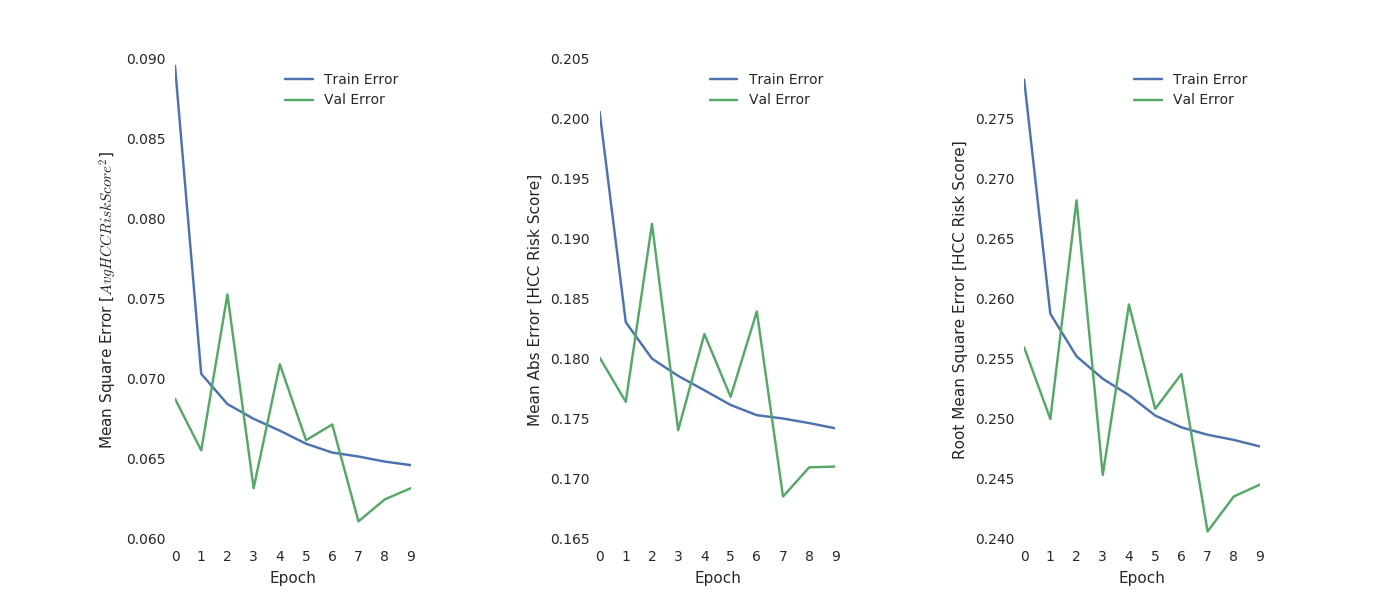

In [64]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print 'epoch = ' + str(epoch) + ' at ' + str(datetime.datetime.now())

EPOCHS = 10

history = model.fit(
  train_dataPd, train_label,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

display(plot_history(history))

In [65]:
loss, mae, mse,rmse,r2 = model.evaluate(test_dataPd, test_label, verbose=0)

print("Testing set Root Mean Square Error: {:5.4f} ".format(rmse))
print("Testing set R2: {:5.4f} ".format(r2))

Testing set Root Mean Square Error: 0.2359 
Testing set R2: 0.6669

#### Tensorflow performance:

##### We were able to achieve the best performance out of our 3 models by using Tensorflow Keras. Our RMSE is .2359 which was 22% better performance than we achieved from our best model in pipeline i.e decision tree models (0.3036). This error is telling us that on average our perdiction is off by .2359 units of the risk score. Compared to the range and distribution of the Risk Scores, this is a very acceptable error. We were also pleased with the model explaining 66% of the variability in our target variable. 

##### We plotted the risiduals to better understand our preditions and it fell in a normal distribution with the average error being zero with a narrow distribution. We were pleased by this result

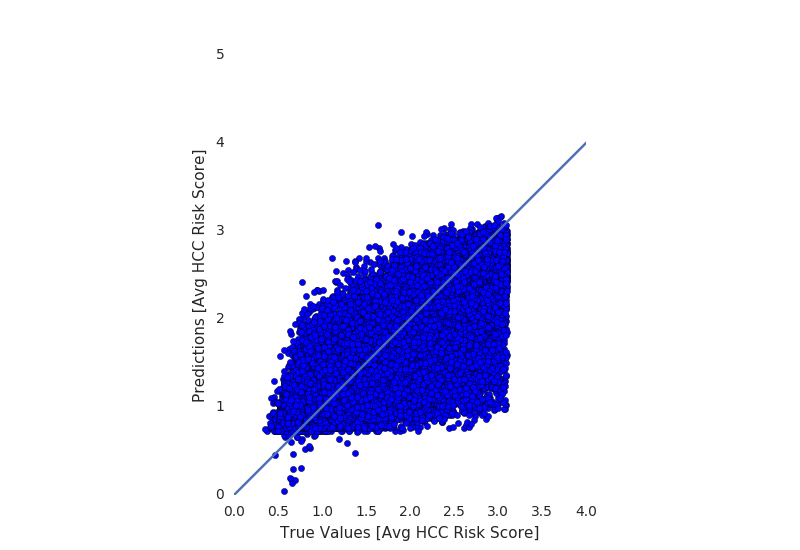

In [67]:
test_predictions = model.predict(test_dataPd).flatten()

fig,ax=plt.subplots()
plt.scatter(test_label, test_predictions)
ax.set_xlabel('True Values [Avg HCC Risk Score]')
ax.set_ylabel('Predictions [Avg HCC Risk Score]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,4])
plt.ylim([0,5])
_ = plt.plot([-100, 100], [-100, 100])
display(fig)

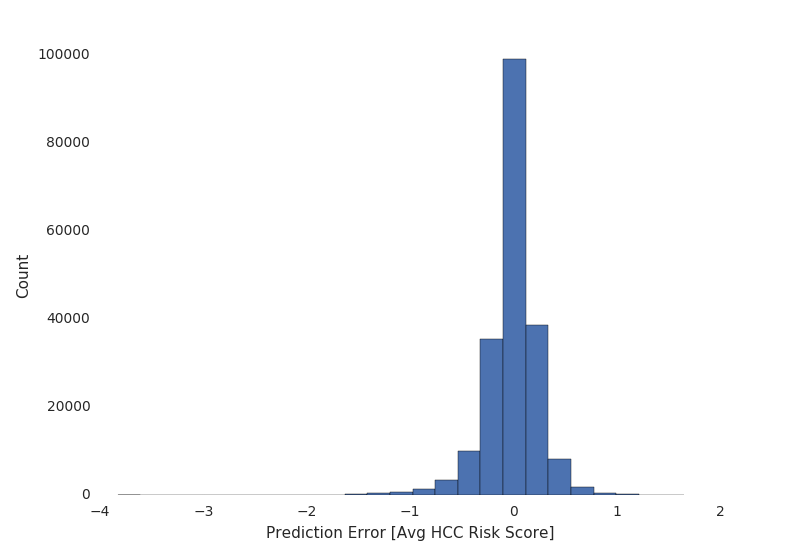

In [68]:
error = test_predictions - test_label
fig,ax=plt.subplots()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Avg HCC Risk Score]")
_ = plt.ylabel("Count")
display(fig)

#### Our Final Recomendation:

###### After running the 3 models, we got the best performance as expected from tensorflow. Based on these results, we suggest to use Tensorflow as the engine of our predictions. We used linear regression in M1 to identify the most important vairables when it comes to predicting Risk Score, however, after running a pipeline we noticed that our model was not stable due to the high RMSE error. Based on our correlation analysis, we suspect the reason is that there is multicolinearity in the dataset causing the high error. Therefore, we recommend not to use a simple linear regression model if it is not implemented in a tensorflow enviornment. Out of linear regression and Decision tree regression, we recommend using a decision tree as it is more flexible when it comes to handling linearity and independency of the predictors.